# Links

# https://www.kaggle.com/rafetcan/heart-failure-modeling-skewness-97-5-acc

# http://ugurturut.com/makine-ogrenmesi/makine-ogrenmesi-k-fold-cross-validation/

# https://www.veribilimiokulu.com/aykiri-gozlem-tespiti-outlier-detection-yontemleri/

# https://teachtomachines.com/2020/07/07/log-donusumu-ile-carpiklik-giderme/

# https://medium.com/datarunner/veri-biliminde-normal-dağılmayan-verilerin-dönüştürülme-transformation-yöntemleri-logaritmik-ef316abb63f2#:~:text=Box-Cox%20dönüşümü%2C%20çarpık%20veriler,<λ%20<5%20aralığına%20sahiptir.

# https://www.youtube.com/watch?v=z5dXpdGaU60






In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from scipy import stats
from scipy.stats import norm, skew, boxcox
from collections import Counter

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, plot_confusion_matrix, auc
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

#XGBOOST
from xgboost import XGBClassifier

#warning
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [2]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Datada boş olan satır var mı diye kontrol yapılıyor: Yok.

In [3]:
print(data.isna().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


 Variable Description:

    ***age : the age of the person with heart failure

    anaemia : Decrease of red blood cells or hemoglobin (boolean)
    
    ***creatinine_phosphokinase : Level of the CPK enzyme in the blood (mcg/L)

    diabetes : If the patient has diabetes (boolean)

    ***ejection_fraction : Percentage of blood leaving the heart at each contraction (percentage)

    high_blood_pressure : If the patient has hypertension (boolean) 

    platelets : Platelets in the blood (kiloplatelets/mL)

    ***serum_creatinine : Level of serum creatinine in the blood (mg/dL)

    serum_sodium : Level of serum sodium in the blood (mEq/L)

    sex : Woman or man (binary)

    smoking : If the patient smokes or not (boolean)

    ***time : Follow-up period (days)

    DEATH_EVENT : If the patient deceased during the follow-up period (boolean)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Veri Görselleştirme:

In [5]:
def plot_hist(variable): #Nümerik değerler için çizdirme fonksiyonu
    print("min {} : {} ".format(variable, min(data[variable])))
    print("max {} : {}".format(variable, max(data[variable])))
    
    plt.figure(figsize=(9,3))
    plt.hist(data[variable], color="darkred")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist ".format(variable))
    plt.show()

min age : 40.0 
max age : 95.0


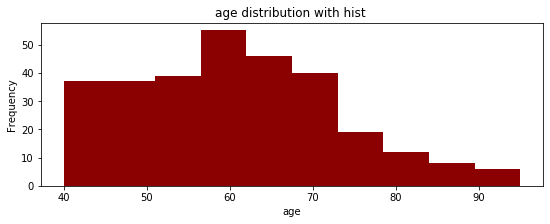

min creatinine_phosphokinase : 23 
max creatinine_phosphokinase : 7861


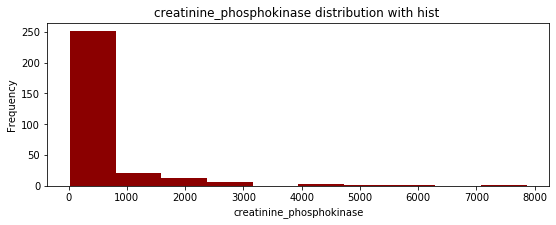

min ejection_fraction : 14 
max ejection_fraction : 80


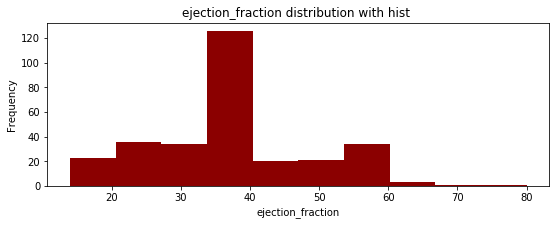

min platelets : 25100.0 
max platelets : 850000.0


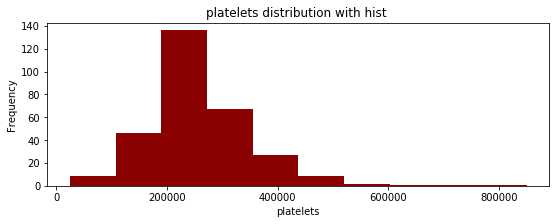

min serum_creatinine : 0.5 
max serum_creatinine : 9.4


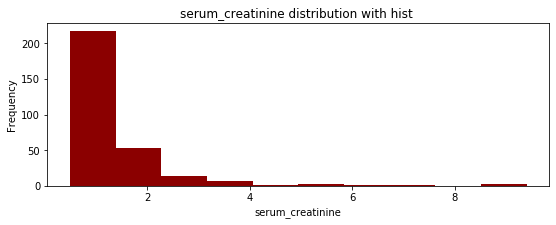

min serum_sodium : 113 
max serum_sodium : 148


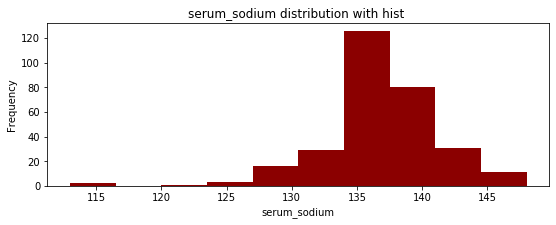

min time : 4 
max time : 285


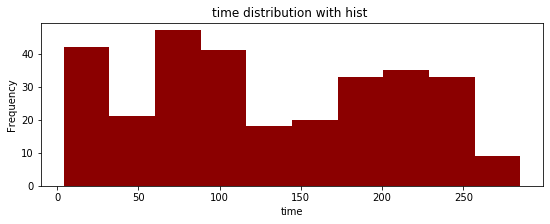

In [6]:
numericVar = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]
for n in numericVar:
    plot_hist(n)

In [7]:
def bar_plot(variable): #kategorik değerler için çizdirme fonksiyonu
    
    # get feature
    var = data[variable]
    #count number of categorical variable (value/sample)
    varValue = var.value_counts()

    #visualize
    plt.figure(figsize=(9,3))
    plt.bar(varValue.index, varValue,color = "lightgreen", edgecolor = "black", linewidth = 2)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

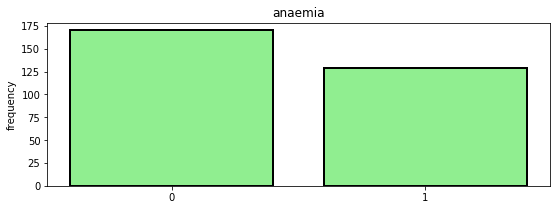

anaemia: 
 0    170
1    129
Name: anaemia, dtype: int64


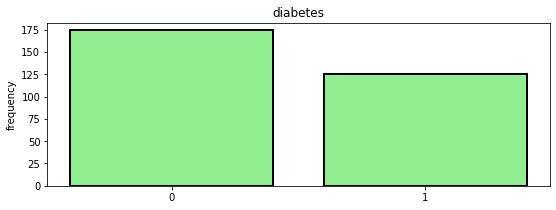

diabetes: 
 0    174
1    125
Name: diabetes, dtype: int64


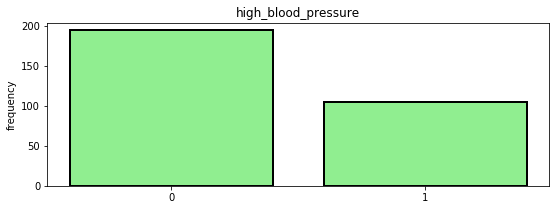

high_blood_pressure: 
 0    194
1    105
Name: high_blood_pressure, dtype: int64


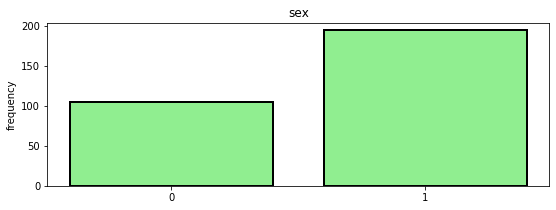

sex: 
 1    194
0    105
Name: sex, dtype: int64


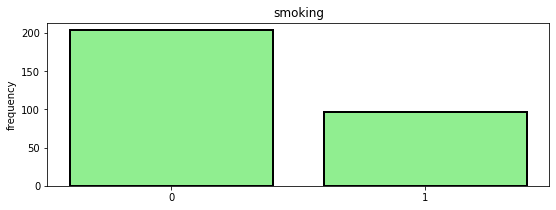

smoking: 
 0    203
1     96
Name: smoking, dtype: int64


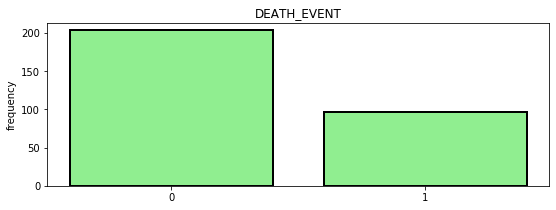

DEATH_EVENT: 
 0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [8]:
category = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
for c in category:
    bar_plot(c)

In [9]:
def detect_outliers(df,features): #Anormallik Tespiti
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1) 
    
    return multiple_outliers

In [10]:
data.loc[detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction",
                                                                        "platelets","serum_creatinine","serum_sodium","time"])]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
38,60.0,0,2656,1,30,0,305000.00,2.3,137,1,0,30,0
52,60.0,0,3964,1,62,0,263358.03,6.8,146,0,0,43,1
163,50.0,1,2334,1,35,0,75000.00,0.9,142,0,0,126,1
200,63.0,1,1767,0,45,0,73000.00,0.7,137,1,0,186,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
217,54.0,1,427,0,70,1,151000.00,9.0,137,0,0,196,1
117,85.0,1,102,0,60,0,507000.00,3.2,138,0,0,94,0
167,59.0,0,66,1,20,0,70000.00,2.4,134,1,0,135,1
281,70.0,0,582,0,40,0,51000.00,2.7,136,1,1,250,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [11]:
data = data.drop(detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction",
                                       "platelets","serum_creatinine","serum_sodium","time"]),axis = 0).reset_index(drop=True)


In [12]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False) #Çarpıklık kontrolü
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
creatinine_phosphokinase,4.827396
serum_creatinine,4.605615
platelets,1.429547
DEATH_EVENT,0.797132
smoking,0.729243
high_blood_pressure,0.583959
ejection_fraction,0.546146
age,0.413840
diabetes,0.358569
anaemia,0.286636


Normalizasyon yapılıyor:

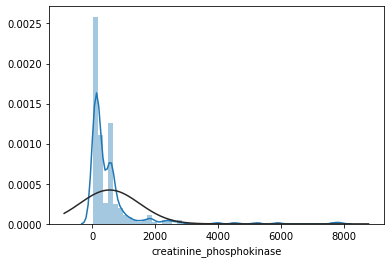

mu creatinine_phosphokinase : 553.121107266436, sigma creatinine_phosphokinase : 943.411428667967



In [13]:
# creatinine_phosphokinase
sns.distplot(data["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["creatinine_phosphokinase"])
print("mu {} : {}, sigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))
print()

In [14]:
data["creatinine_phosphokinase"], lam = boxcox(data["creatinine_phosphokinase"])

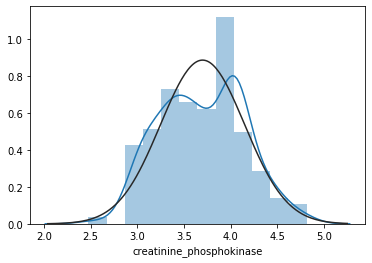

mu creatinine_phosphokinase : 3.698843171315633, sigma creatinine_phosphokinase : 0.4504255141000855



In [15]:
# creatinine_phosphokinase
sns.distplot(data["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["creatinine_phosphokinase"])
print("mu {} : {}, sigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))
print()

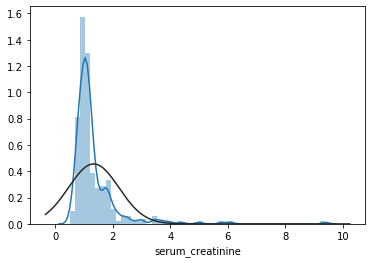

mu serum_creatinine : 1.333114186851211, sigma serum_creatinine : 0.8748528244624999



In [16]:
# serum_creatinine
sns.distplot(data["serum_creatinine"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["serum_creatinine"])
print("mu {} : {}, sigma {} : {}".format("serum_creatinine", mu, "serum_creatinine", sigma))
print()

In [17]:
data["serum_creatinine"], lam_serum_creatine = boxcox(data["serum_creatinine"])

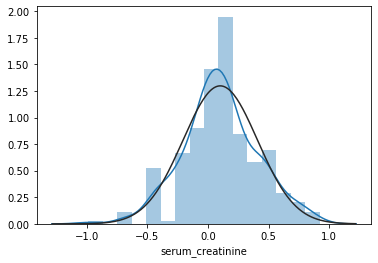

mu serum_creatinine : 0.10109147159013519, sigma serum_creatinine : 0.3073176761803753



In [18]:
# serum_creatinine
sns.distplot(data["serum_creatinine"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["serum_creatinine"])
print("mu {} : {}, sigma {} : {}".format("serum_creatinine", mu, "serum_creatinine", sigma))
print()

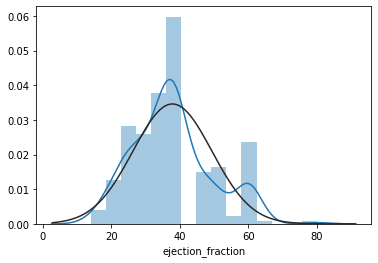

mu ejection_fraction : 37.8719723183391, sigma smejection_fractionoking : 11.526149444782293



In [19]:
# ejection_fraction
sns.distplot(data["ejection_fraction"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["ejection_fraction"])
print("mu {} : {}, sigma {} : {}".format("ejection_fraction", mu, "smejection_fractionoking", sigma))
print()

In [20]:
data["ejection_fraction"], lam_serum_creatine = boxcox(data["ejection_fraction"])

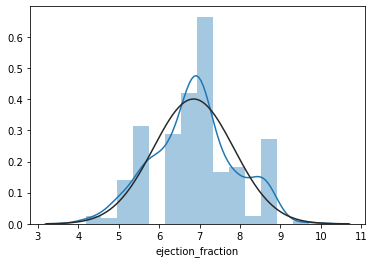

mu ejection_fraction : 6.8528622136803135, sigma smejection_fractionoking : 0.9951607969085129



In [21]:
# ejection_fraction
sns.distplot(data["ejection_fraction"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["ejection_fraction"])
print("mu {} : {}, sigma {} : {}".format("ejection_fraction", mu, "smejection_fractionoking", sigma))
print()

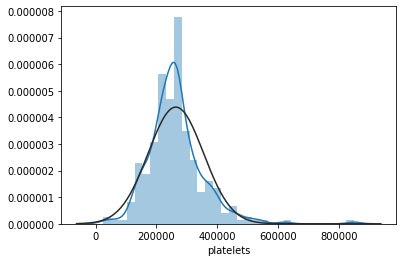

mu platelets : 263597.55266435986, sigma platelets : 90929.19587502987



In [22]:
# platelets
sns.distplot(data["platelets"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["platelets"])
print("mu {} : {}, sigma {} : {}".format("platelets", mu, "platelets", sigma))
print()

In [23]:
data["platelets"], lam_serum_creatine = boxcox(data["platelets"])

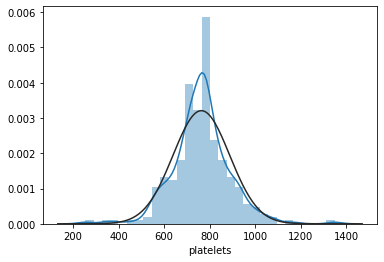

mu platelets : 763.3363077948457, sigma platelets : 124.37245302525076



In [24]:
# platelets
sns.distplot(data["platelets"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["platelets"])
print("mu {} : {}, sigma {} : {}".format("platelets", mu, "platelets", sigma))
print()

In [25]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness_new = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness_new

,skewed
DEATH_EVENT,0.797132
smoking,0.729243
high_blood_pressure,0.583959
age,0.413840
diabetes,0.358569
anaemia,0.286636
platelets,0.153154
time,0.125442
creatinine_phosphokinase,0.038332
serum_creatinine,-0.005096


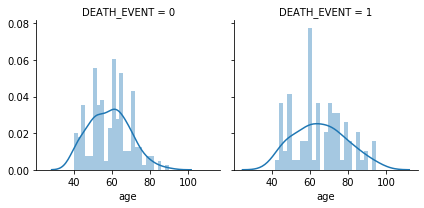

In [26]:
#AGE
g = sns.FacetGrid(data, col = "DEATH_EVENT")
g.map(sns.distplot, "age", bins = 25)
plt.show()

In [27]:
X = data.drop("DEATH_EVENT", axis = 1)
y = data.DEATH_EVENT

In [28]:
print("Before Smote")
y.value_counts()

Before Smote


0    198
1     91
Name: DEATH_EVENT, dtype: int64

In [29]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

In [30]:
print("After Smote")
y_sm.value_counts()

After Smote


1    198
0    198
Name: DEATH_EVENT, dtype: int64

In [31]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X_sm, y_sm, test_size = test_size, random_state = 42)

In [32]:
print("X_train shape {}, len {}.".format(X_train.shape,len(X_train)))
print("X_test shape {}, len {}.".format(X_test.shape,len(X_test)))
print("Y_train shape {}, len {}.".format(Y_train.shape,len(Y_train)))
print("Y_test shape {}, len {}.".format(Y_test.shape,len(Y_test)))

X_train shape (316, 12), len 316.
X_test shape (80, 12), len 80.
Y_train shape (316,), len 316.
Y_test shape (80,), len 80.


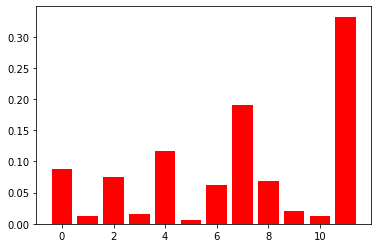

In [33]:
model_rnd = RandomForestClassifier()
model_rnd.fit(X_train, Y_train)
importance = model_rnd.feature_importances_

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color = "red")
plt.show()

In [34]:
import pickle
pickle.dump(model_rnd, open('model2.pkl','wb'))

In [35]:
model2 = pickle.load(open('model2.pkl','rb'))

In [38]:
print(model2.predict([[75, 0, 582, 0, 20, 1, 265000, 1.9, 130, 1, 0, 4  ]]))

[1]


In [34]:
x_train_random_forest = X_train[["age","creatinine_phosphokinase","ejection_fraction","serum_creatinine","time"]]
x_test_random_forest = X_test[["age","creatinine_phosphokinase","ejection_fraction","serum_creatinine","time"]]

In [35]:
random_forest_model = RandomForestClassifier(max_depth=7, random_state=25)
random_forest_model.fit(x_train_random_forest, Y_train)
y_pred_random_forest = random_forest_model.predict(x_test_random_forest)
cm_random_forest = confusion_matrix(y_pred_random_forest, Y_test)
acc_random_forest = accuracy_score(Y_test, y_pred_random_forest)
print("RESULT")
print("Random Forest Model Acc : ",acc_random_forest)
print("Random Forest Model Cm : ",cm_random_forest)

RESULT
Random Forest Model Acc :  0.975
Random Forest Model Cm :  [[38  1]
 [ 1 40]]


In [36]:
import pickle

In [38]:
pickle.dump(random_forest_model, open('model.pkl','wb'))

In [39]:
model = pickle.load(open('model.pkl','rb'))

In [48]:
print(model.predict([[63, 61, 40, 1.1, 86, ]]))

[0]
